<a href="https://colab.research.google.com/github/ShizaAli/Speech-Recognition-using-CNN/blob/main/Speech_Recognition_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import IPython
import matplotlib.pyplot as plt
import scipy
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling2D, Flatten
from keras import layers
import os
from sklearn.preprocessing import OneHotEncoder
import librosa
import librosa.display
from pathlib import Path
from PIL import Image
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/MyDrive/Medical Speech, Transcription, and Intent'

/content/drive/MyDrive/Medical Speech, Transcription, and Intent


In [4]:
# Importing the dataset
recordings = pd.read_csv('overview-of-recordings.csv')
recordings = recordings[['file_name','phrase','prompt','speaker_id']]
recordings.head()

,file_name,phrase,prompt,speaker_id
0,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,43453425
1,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,43719934
2,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,43719934
3,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,31349958
4,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,43719934


In [5]:
cd 'recordings/test'

/content/drive/MyDrive/Medical Speech, Transcription, and Intent/recordings/test


In [6]:
a = []
for f in recordings['file_name']:
 a.append(os.path.isfile(f))

train_df = recordings[a]

In [7]:
files = train_df['file_name']
print(len(train_df))

5169


In [8]:
train_df.head()

,file_name,phrase,prompt,speaker_id
0,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,43453425
1,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,43719934
2,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,43719934
3,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,31349958
4,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,43719934


Text(0.5, 1.0, 'Frequency of Prompts')

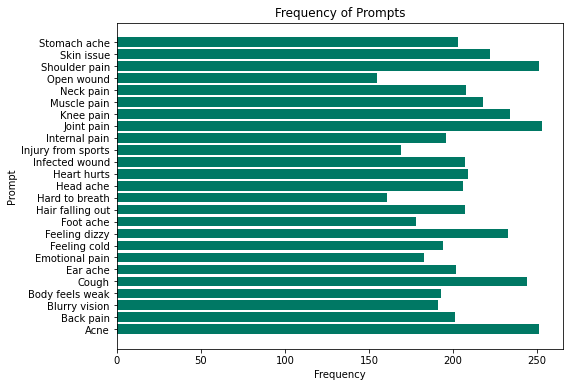

In [9]:
# Prompts Freq Distribution
total_prompts = train_df.groupby('prompt').count()['file_name'].reset_index()
plt.figure(figsize=(8, 6)) 
plt.barh(total_prompts['prompt'],total_prompts['file_name'], color='#007864')
plt.ylabel('Prompt')
plt.xlabel('Frequency')
plt.title('Frequency of Prompts')

In [55]:
# Sample audio
import IPython
audio = "1249120_1853182_11719913.wav"
IPython.display.Audio(audio)

In [57]:
x , sr = librosa.load(audio)
x

array([ 6.65368952e-06,  3.45119151e-05,  2.19024696e-05, ...,
       -2.36711785e-05, -1.03607645e-05, -1.08778095e-05], dtype=float32)

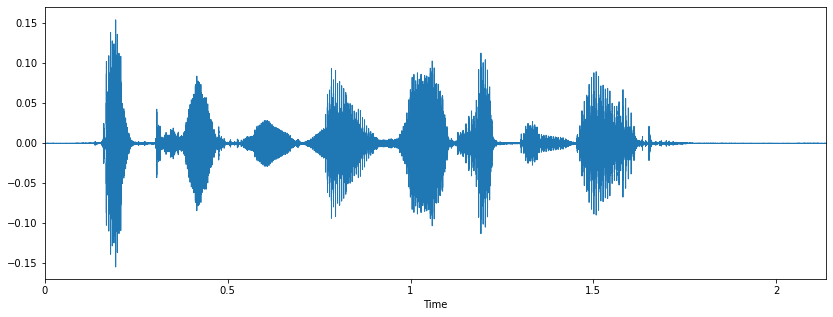

In [58]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

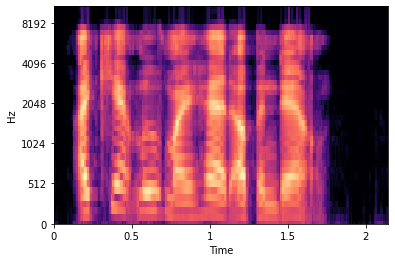

In [59]:
# Static
S = librosa.feature.melspectrogram(x, sr=sr, n_fft=1024,hop_length=int(sr*0.01),win_length=int(sr*0.025), window='hamm',n_mels=40)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=int(sr*0.01), x_axis='time', y_axis='mel');

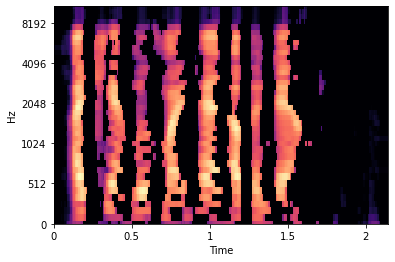

In [60]:
# Delta
S1 = librosa.feature.delta(S, order=1)
S_DB = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=int(sr*0.01), x_axis='time', y_axis='mel');

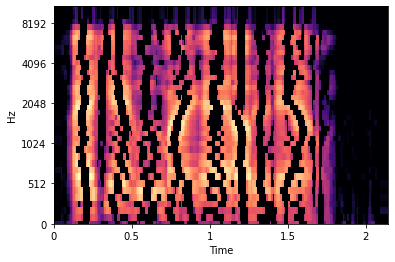

In [61]:
# Delta - Delta
S2 = librosa.feature.delta(S, order=2)
S_DB = librosa.power_to_db(S2, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=int(sr*0.01), x_axis='time', y_axis='mel');

In [14]:
# The function to create spectrograms
def spectrogram(file):
    x, sar = librosa.load(file)
    fig = plt.figure(figsize=[2,2])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(x, sr=sar, n_fft=2400, hop_length=int(sar*0.01),win_length=int(sar*0.025), window='hamm',n_mels=40)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB);
    filename = Path('Spect/' + file + '.jpg')
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del file,x,sar,fig,ax,S

In [15]:
from tqdm import tqdm_notebook as tqdm
for file in tqdm(train_df['file_name'], total=len(train_df)):
   spectrogram(file)

In [16]:
specs = [f'Spect/{i}.jpg' for i in train_df.file_name]

In [17]:
len(specs)

5169

In [18]:
x_wav_array = np.array([np.array(Image.open(fname)) for fname in specs[:2000]])

In [19]:
x_wav_array.shape

(2000, 604, 620, 3)

In [20]:
train_df = train_df[:2000]

In [21]:
# Preparing labels - One Hot Encoding
enc = OneHotEncoder(handle_unknown='ignore')
prompt_array = train_df['prompt'].values.reshape(-1,1)
labels_onehot = enc.fit_transform(prompt_array).toarray()

labels_onehot.shape

(2000, 25)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train_df = train_df.reset_index(drop=True)
train_df

,file_name,phrase,prompt,speaker_id
0,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,43453425
1,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,43719934
2,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,43719934
3,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,31349958
4,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,43719934
...,...,...,...,...
1995,1249120_35197064_34761714.wav,I get an ear ache when it is cold,Ear ache,35197064
1996,1249120_35197064_38623107.wav,Sharp pain and heavy breathing,Internal pain,35197064
1997,1249120_35197064_73388610.wav,When I stand up too quickly I start to feel di...,Feeling dizzy,35197064
1998,1249120_35197064_83703590.wav,When I play football I have joint pain.,Joint pain,35197064


In [24]:
#Splitting dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(train_df.index, labels_onehot, test_size = .2)

In [25]:
training_data = x_wav_array[x_train]
testing_data = x_wav_array[x_test]

In [26]:
training_data.shape

(1600, 604, 620, 3)

In [27]:
training_data[0].shape

(604, 620, 3)

In [28]:
prompts = len(train_df['prompt'].unique())
prompts

25

In [29]:
#CNN model FWS
model = Sequential()
model.add(Conv1D(10, 8, activation='relu', strides=2,kernel_initializer='random_normal',input_shape=(604,620,3)))
model.add(MaxPooling2D(pool_size=(6, 6), strides=(2, 2)))
model.add(Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(25, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 604, 307, 10)      250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 300, 151, 10)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 453000)            0         
                                                                 
 dense (Dense)               (None, 1000)              453001000 
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 25)                25025     
                                                        

In [30]:
history = model.fit(training_data, y_train,epochs=10, batch_size=20, validation_split = .2)

Epoch 1/10
64/64 [==============================] - 25s 351ms/step - loss: 839.8607 - accuracy: 0.0359 - val_loss: 7.6446 - val_accuracy: 0.0375
Epoch 2/10
64/64 [==============================] - 22s 340ms/step - loss: 4.8557 - accuracy: 0.1305 - val_loss: 4.9737 - val_accuracy: 0.0344
Epoch 3/10
64/64 [==============================] - 23s 358ms/step - loss: 2.4883 - accuracy: 0.3320 - val_loss: 4.6086 - val_accuracy: 0.0312
Epoch 4/10
64/64 [==============================] - 23s 360ms/step - loss: 1.9553 - accuracy: 0.4867 - val_loss: 4.7711 - val_accuracy: 0.0312
Epoch 5/10
64/64 [==============================] - 23s 358ms/step - loss: 1.6220 - accuracy: 0.5938 - val_loss: 4.9225 - val_accuracy: 0.0312
Epoch 6/10
64/64 [==============================] - 23s 357ms/step - loss: 1.3338 - accuracy: 0.6789 - val_loss: 5.5310 - val_accuracy: 0.0437
Epoch 7/10
64/64 [==============================] - 22s 340ms/step - loss: 1.0794 - accuracy: 0.7500 - val_loss: 6.9565 - val_accuracy: 0.02